In [1]:
import os
import random
from shutil import copy2
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


In [ ]:
# Determine the device (if, elif, else, f-string) to use for PyTorch
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


# Loading data

In [ ]:
# Define the data directory
data_dir = os.path.join("data_p2", "train")
print("Data directory:", data_dir)

Data directory: data_p2\train


In [3]:
# use the directory names as classes.
classes =os.listdir(data_dir )
classes

['cassava-bacterial-blight-cbb',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-healthy',
 'cassava-mosaic-disease-cmd']

In [ ]:
# funciton, control flow(if, for), and plotting
def sample_images(data_path, classname):
    # Gets the files in the directory
    class_dir = os.path.join(data_path, classname)
    if not os.path.exists(class_dir):
        return "Invalid directory"
    image_list = os.listdir(class_dir)
    if len(image_list) < 4:
        return "Not enough images in folder"

    # Pick four random images
    images_sample = random.sample(image_list, 4)

    # Plot them
    plt.figure(figsize=(20, 20))
    for i in range(4):
        img_loc = os.path.join(class_dir, images_sample[i])
        img = PIL.Image.open(img_loc)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

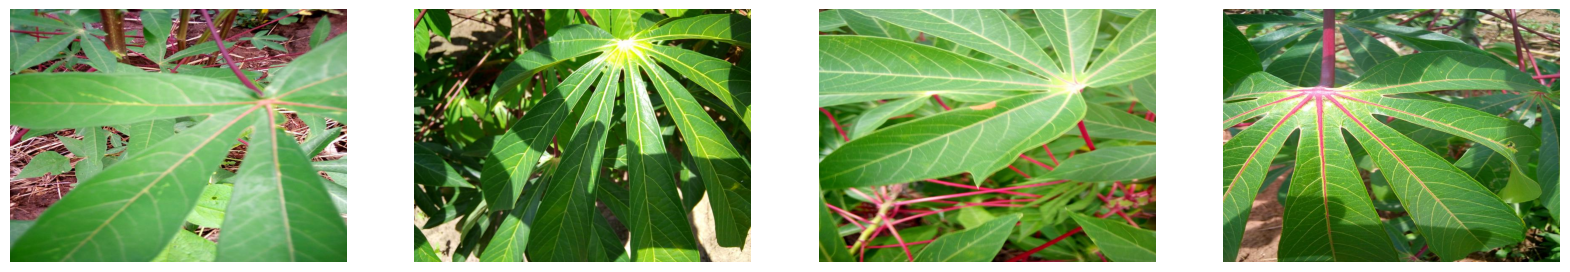

In [7]:
# call the function
sample_images(data_dir, "cassava-healthy")

In [9]:
# A robust, improved sample_images function
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt
import difflib

def sample_images(data_path, classname, n=4):
    data_path = Path(data_path)
    class_dir = data_path / classname

    # Diagnostics
    if not data_path.exists():
        raise FileNotFoundError(f"Data path does not exist: {data_path.resolve()}")
    if not data_path.is_dir():
        raise NotADirectoryError(f"Data path is not a directory: {data_path.resolve()}")

    if not class_dir.exists() or not class_dir.is_dir():
        classes = sorted([p.name for p in data_path.iterdir() if p.is_dir()])
        suggestion = difflib.get_close_matches(classname, classes, n=3)
        msg = f"Class directory not found: {class_dir}\nAvailable classes: {classes}"
        if suggestion:
            msg += f"\nDid you mean: {suggestion} ?"
        raise FileNotFoundError(msg)

    # Collect image files (filter common extensions)
    image_files = [p for p in class_dir.iterdir()
                   if p.is_file() and p.suffix.lower() in ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')]

    if len(image_files) < n:
        raise ValueError(f"Not enough image files in {class_dir} (found {len(image_files)}, need {n})")

    images_sample = random.sample(image_files, n)

    plt.figure(figsize=(4*n, 4))
    for i, img_path in enumerate(images_sample, 1):
        img = Image.open(img_path)
        plt.subplot(1, n, i)
        plt.imshow(img)
        plt.title(img_path.name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


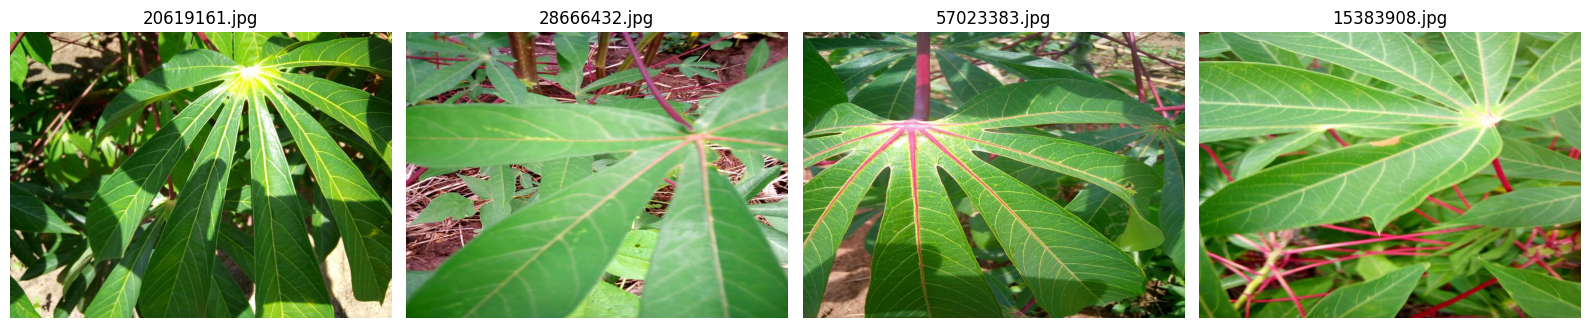

In [10]:
# call the function
sample_images(data_dir, "cassava-healthy")

cassava-bacterial-blight-cbb


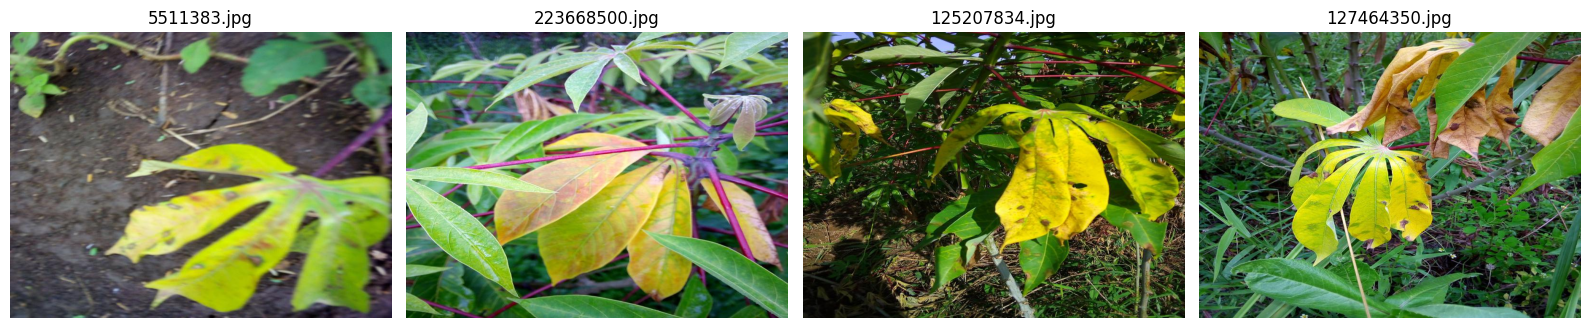

In [14]:
# Example usage with a different class
class_name = classes[0]
print(class_name)

sample_images(data_dir, class_name)

In [15]:
# Convert the image to RGB if it is not already
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [16]:
# Preparing the data transformation
transform = transforms.Compose([
    ConvertToRGB(),  # Ensure image is in RGB mode
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to tensor with shape [C, H, W]
])

In [18]:
batch_size = 32
dataset = datasets.ImageFolder(root = data_dir, transform = transform)
dataset_loader = DataLoader(dataset, batch_size = batch_size)

batch_shape = next(iter(dataset_loader))[0].shape
print("Getting batches of shape:", batch_shape)

Getting batches of shape: torch.Size([20, 3, 224, 224])


In [19]:
# normalizationNormalize the images data with  mean of 0 & a standard deviation of 1
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [20]:
# run the function to get mean and std
from tqdm import tqdm
mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")


Mean: tensor([0.4449, 0.5337, 0.2907])
Standard deviation: tensor([0.2186, 0.2174, 0.2031])


In [21]:
# Preparing the data transformation with normalization
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [23]:
# Create the dataset with normalization
norm_dataset = datasets.ImageFolder(root=data_dir, transform=transform_norm)
# Create the DataLoader for the normalized dataset
norm_loader = DataLoader(dataset=norm_dataset, batch_size=32)

In [24]:
# run the function to get mean and std
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Mean: tensor([-1.6446e-07, -1.7857e-07, -8.1744e-08])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])
